## Introduction & Problem Statement 
In this project, we will implement a machine learning model using the Bengaluru Housing Prices dataset. The aim of the project is to predict the price of property on the basis of certain features, after learning from the training data. We will see the process of data cleaning, feature engineering, outlier detection; how to build an effective machine learning model ready for deployment. As always, first import the necessary libraries. 

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

## All About the Data

The data set contains **13,000 rows** of various features of real estate properties for various location within & around the Indian city of Bengaluru. The columns are-

- `Area Type`: Type of Plot
- `Availability`: Ready to Move or Not
- `Location`: Region of Bangalore
- `Size`: BHK
- `Society`: Colony in which the House is Present in
- `Total Sq. Ft`: Total Area
- `Bath`: Number of Bathrooms
- `Balcony`: Number of Balconies
- `Price`: Cost in Lakhs of Indian Rupees (₹)


In [2]:
#load the csv into a dataframe

df1 = pd.read_csv("/kaggle/input/bangalore-housing-prices/BHP.csv")

#peek at the top 5 entries
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
#the last five entries

df1.tail()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.0
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.0
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.0
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.0
13319,Super built-up Area,Ready To Move,Doddathoguru,1 BHK,NaN,550,1.0,1.0,17.0


In [4]:
#number of rows and columns
df1.shape

(13320, 9)

In [5]:
#relevant information about data types and missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
#basic statistics about the numerical columns of the dataset

df1.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [7]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

## Data Exploration 

Let's look at some of the columns to determine whether they are useful for the model to be built. First, `area_type`. 

In [8]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [9]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

> **Drop features like `balcony`, `area_type`, `availability` , `society` as they are text features which could be converted into dummy variables but that would add more columns to an already large data set. The intention is always to simplify things.**

In [10]:
df2 = df1.drop(['balcony', 'area_type', 'availability' , 'society'], axis = 'columns')
df2.shape 

(13320, 5)

## Tackle Missing/Null Values

- There multiple options to impute for missing values such as filling the missing numbers with the mean/median or some comaptible aggregate value. 
- The other method is to drop the rows with missing values altogether. This depends on the problem at hand. If the number of rows are low, it is easier to drop them for significant features. On the other hand, if an *important feature* has a large number of missing values, skewing the distribution of that column, then one should think about imputation of the values. 

Here, we will simply drop the rows with the null values.

In [11]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [12]:
df2.shape

(13320, 5)

In [13]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [14]:
df3.shape

(13246, 5)

## Feature Engineering

The concept of `feature engineering` involves techniques of data manipulation, understanding distributions of the features and making compatible changes for the model to be built. 

First, we will convert the `size` feature into a numerical feature with text manipulation. 

### Create a new feature (integer) for BHK

The `size` column has string inputs such as 2bhk, 3bhk, 4bhk etc. We need to extract the number from it which will be used as the input for the model.

In [15]:
#split the text input and extract the first element

df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))
df3.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [16]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


> There are properties with more 20 bedrooms. Let's crosscheck.

In [17]:
df3[df3.bhk > 10]

,location,size,total_sqft,bath,price,bhk
459,1 Giri Nagar,11 BHK,5000,9.0,360.0,11
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
1768,1 Ramamurthy Nagar,11 Bedroom,1200,11.0,170.0,11
3379,1Hanuman Nagar,19 BHK,2000,16.0,490.0,19
3609,Koramangala Industrial Layout,16 BHK,10000,16.0,550.0,16
3853,1 Annasandrapalya,11 Bedroom,1200,6.0,150.0,11
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43
4916,1Channasandra,14 BHK,1250,15.0,125.0,14
6533,Mysore Road,12 Bedroom,2232,6.0,300.0,12
7979,1 Immadihalli,11 BHK,6000,12.0,150.0,11


In [18]:
df3[df3.bhk > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


- **A 43 room house cannot be 2400 square feet. Further investigation is required.**
- **There seems to be houses with the same number of bedrooms and bathrooms. Needs more information** 

### Square Feet of the apartment

Let's see the `total_sqft` column now. There seems to be quite significant quality and consistency issues with this column.

In [19]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

- **There seems to be ranges of figures for some rows. This column need to be revisited and the numbers need to be consistent in scale.**

> Since we require float numbers for `total_sqft` column, we will make try-except block which converts the number into float.

In [20]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True 

In [21]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Problems that remain:

- **There are different measures like square meter. They all need to be the same measure and preferably a single number for each row**
- **Drop the corner cases as the number of them is less** 
- **Convert sq.mtr to square feet using a converter function** 

In [22]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None     

In [23]:
df4 = df3.copy()
df4['total_sqft'] = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


> **Thus we have successfully dealt with the inconsistencies of the `total_sqft` column.**

In [24]:
#example to verify the methods applied

df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [25]:
#The Yelahanka 4BHK property had the area range of 2100-2850 sqft. 
#The function is correctly applied as it returns the average of the range.

(2100+2850)/2


2475.0

### Price per square foot

The `price_per_sqft` is an important feature for real estate price determination. We need to add this feature in the model. 

In [26]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

### Location

Another important factor for real estate price determination is the location of the property. A well connected location will have higher prices vis-a-vis a location which is a little further from the city center, for example. 

Here, we will look at the number of properties for each location by the method of text manipulation. 

In [28]:
df5.location = df5.location.apply(lambda x : x.strip())

location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [29]:
location_stats.values.sum()

13200

In [30]:
len(location_stats)

1287

In [31]:
#localities with more than 10 properties/data points

len(location_stats[location_stats>10])

240

In [32]:
#localities with less than 10 properties/data points

len(location_stats[location_stats<=10])

1047

## Dimensionality Reduction

> **Dimensionality reduction** is the process of reducing the number of features *while* retaining as much information of the dataset as possible. 

Any location having less than 10 data points should be tagged as `other` location. This way number of categories can be reduced by huge amount. Later on, when we do one hot encoding, it will help us with having fewer dummy columns.

In [33]:
location_stats_less_than_ten = location_stats[location_stats<=10]
location_stats_less_than_ten

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [34]:
df5.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [35]:
len(df5.location.unique())

1287

In [36]:
df5.location = df5.location.apply(lambda x : 'other' if x in location_stats_less_than_ten else x)

len(df5.location.unique())

241

In [37]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal Using Business Logic
Let us assume that a real estate expert has been consulted who is of the opinion that the average square ft per bedroom is 300 (i.e. a 2 bhk apartment is minimum 600 sqft).

If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. **We will remove such outliers by keeping our minimum threshold per bhk to be 300 sqft.**

In [38]:
df5.columns

Index(['location', 'size', 'total_sqft', 'bath', 'price', 'bhk',
       'price_per_sqft'],
      dtype='object')

In [39]:
df5[df5.total_sqft/df5.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely.**

In [40]:
df5.shape

(13200, 7)

In [41]:
df6 = df5[~(df5.total_sqft/df5.bhk < 300)]
df6.shape

(12456, 7)

## Outlier Removal with Mean & Standard Deviation

Another way to scale a column is assuming a normal distribution, i.e, the values are ditributed in such a way that the mean and variance are constant. This is useful in cases where there seems to be anomalies within the column that skews the ditribution in some form. 

Normal distribution, also known as the **Gaussian distribution**, is a probability distribution that is symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far from the mean. The normal distribution appears as a *"bell curve"* when graphed. 

In [42]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**For Bengaluru (or any major city in India), price per square foot cannot be INR 267.83. The maximum also seems to be an anomaly.** 

In [43]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [44]:
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

In [45]:
df7.sample(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
2292,Electronic City Phase II,3 BHK,1310.0,2.0,37.83,3,2887.786260
8161,other,4 Bedroom,2150.0,4.0,80.00,4,3720.930233
9418,other,3 BHK,1240.0,2.0,63.00,3,5080.645161
3098,Hennur Road,2 BHK,1232.0,2.0,69.60,2,5649.350649
1040,Begur Road,3 BHK,1500.0,2.0,70.00,3,4666.666667
6026,Sarjapur,2 BHK,920.0,2.0,33.00,2,3586.956522
905,Bannerghatta Road,2 BHK,1280.0,2.0,60.16,2,4700.000000
9012,other,3 BHK,1424.0,2.0,55.00,3,3862.359551
4228,Kannamangala,2 BHK,957.0,2.0,52.50,2,5485.893417
4941,Malleshwaram,1 BHK,580.0,1.0,45.00,1,7758.620690


**Now, the `price_per_sqft` column is scaled and compatible for the model.**

## Visualizing the Outliers- Before & After

We will build a helper function to visualize the outliers for 2bhk and 3bhk properties. This will give a better understanding of the problem.

In [46]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]  #filtering the 2bhk and 3bhk with location                                              #along with location
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50) #scatter with price and bhk 
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='red',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees (₹))")
    plt.title(location)
    plt.legend() 

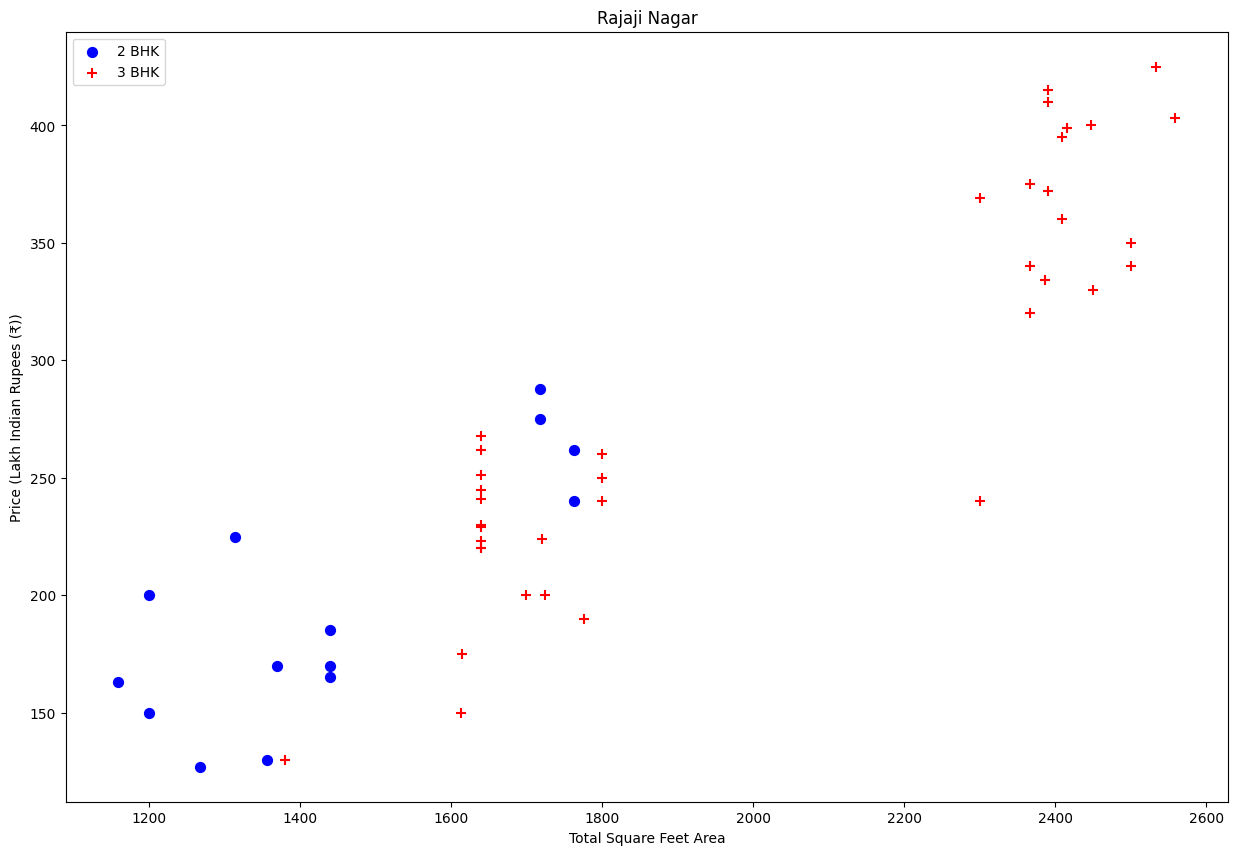

In [47]:
plot_scatter_chart(df7, 'Rajaji Nagar')

**Observations**

- There are two clusters for 2bhk and 3bhk properties. 2bhk's typically sized within 1300 sqft while the 3bhk's are sized at 2300 sqft or greater. 

- For square feet area of around 1700, **the price of 2bhk is higher than 3bhk** for the same locality of Rajaji Nagar.

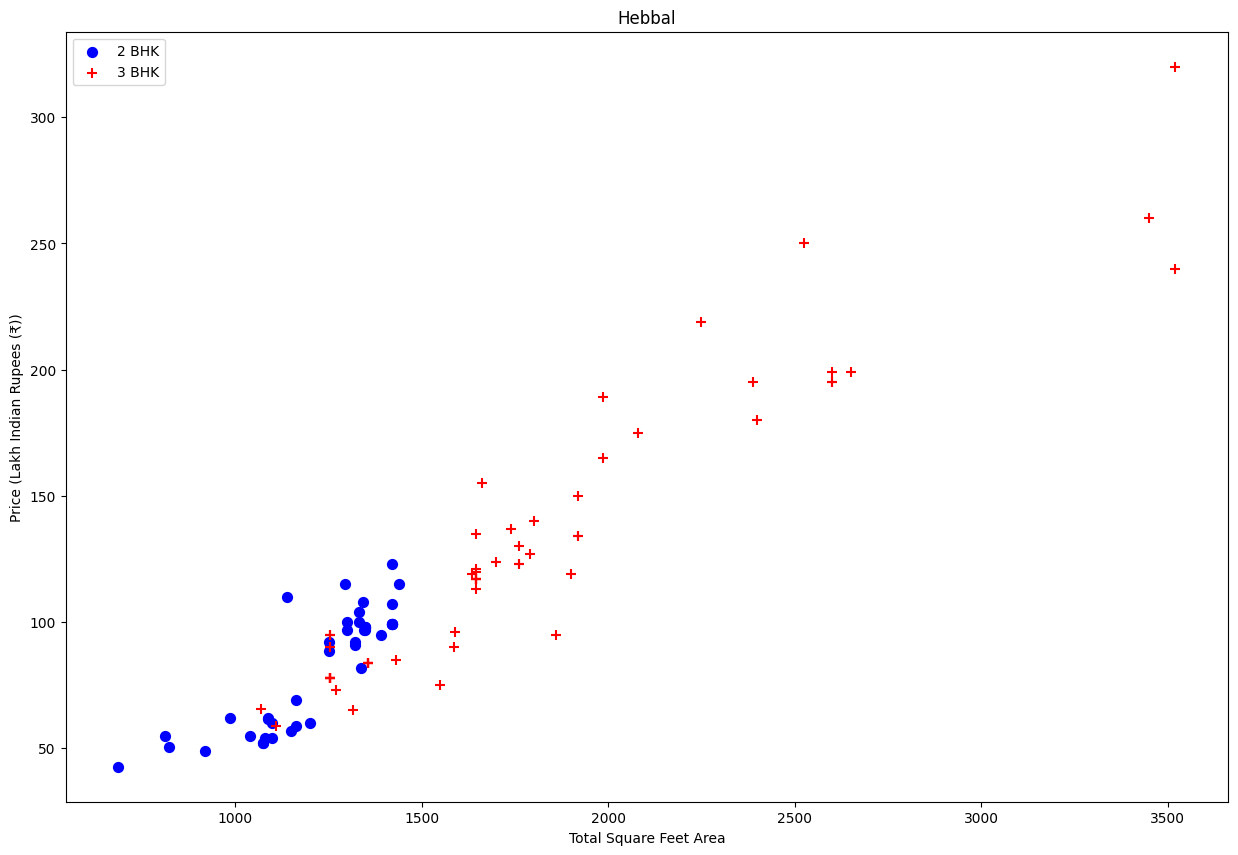

In [48]:
plot_scatter_chart(df7, 'Hebbal')

**Observations**

- Two cluster groups for two and three bhk properties are seen here as well but not as well marked as the one for Rajaji Nagar. Here, it seems that the 3bhk properties begin at a size slightly bigger than the 2bhk ones. 

- Outliers are present. There are a few **2bhk properties which are priced higher than the 3bhk ones** for a similar size range of around 1300 sqft. 

### How to remove the outliers?

As visualized above, it is necessary to remove the properties for a particular location where the 2bhk is priced higher than the 3bhk with similar sqft area. 

For this, we will build a dictionary of statistics per bhk like so-

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    } 



In [49]:
#helper function

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')   

In [50]:
df7.shape

(10242, 7)

In [51]:
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

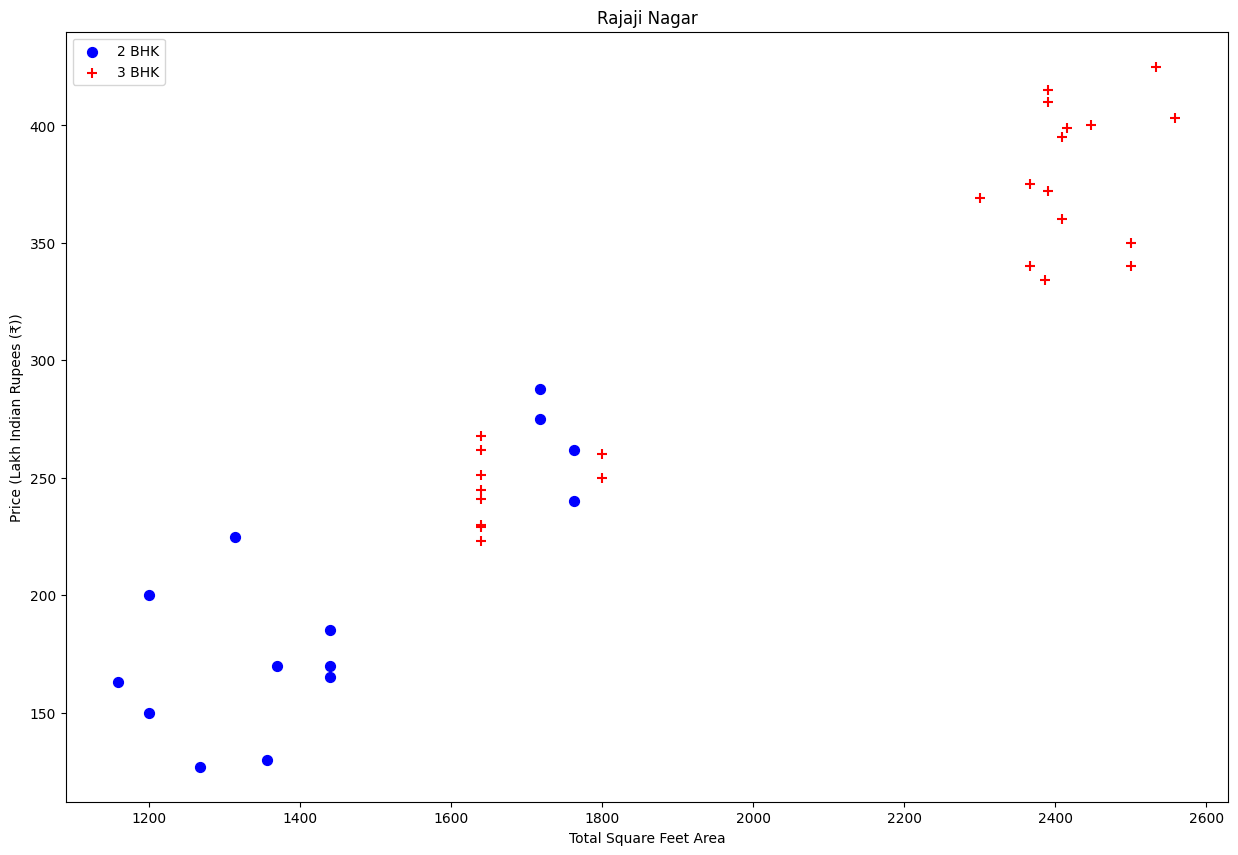

In [52]:
plot_scatter_chart(df8, 'Rajaji Nagar')

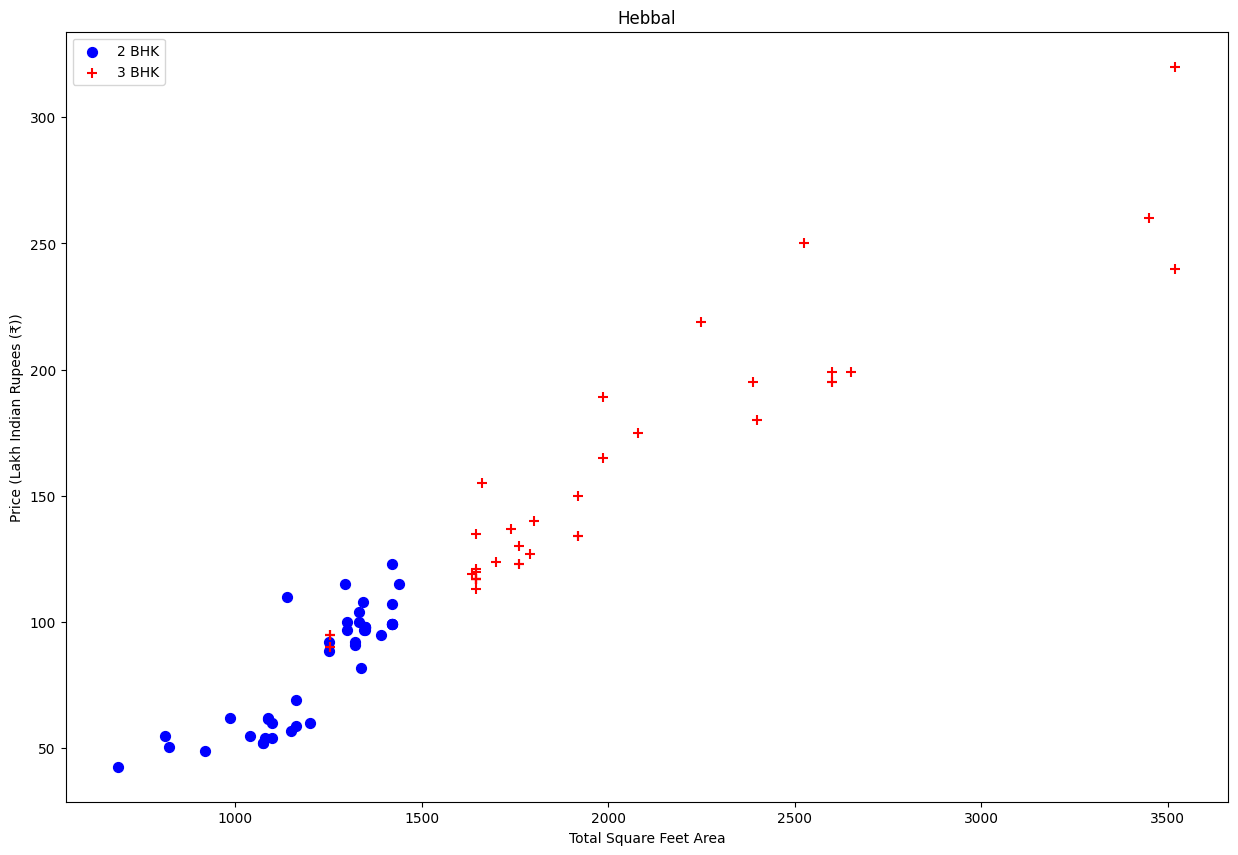

In [53]:
plot_scatter_chart(df8,"Hebbal") 

> **The outliers have been removed successfully**

Let us now look at the final count for price per sqft.

Text(0, 0.5, 'Count')

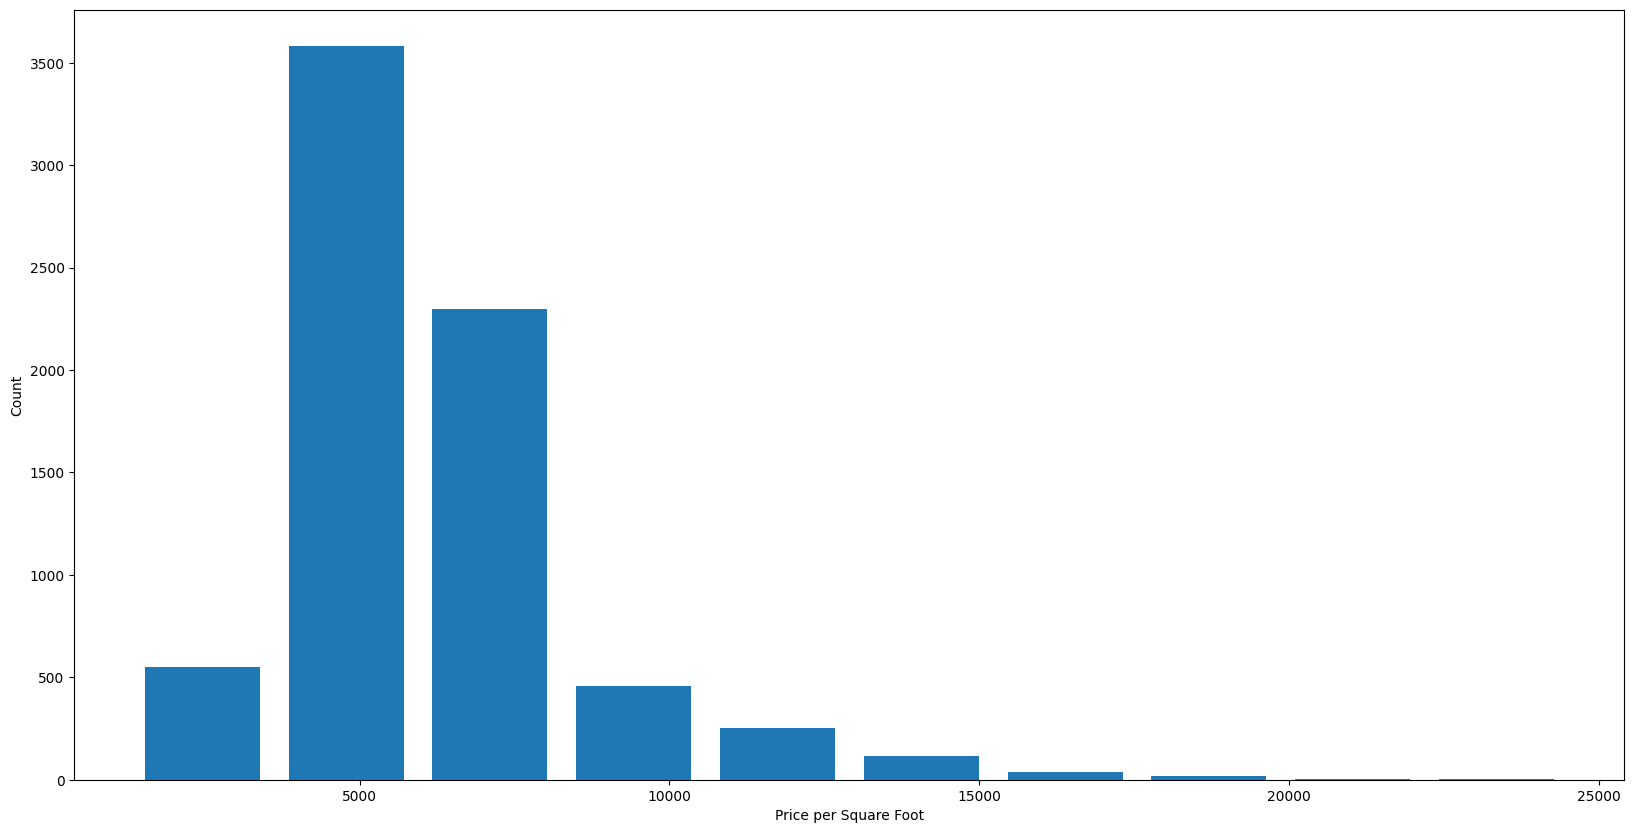

In [54]:
plt.figure(figsize = (20, 10))
plt.hist(df8.price_per_sqft, rwidth = 0.8)
plt.xlabel('Price per Square Foot')
plt.ylabel('Count') 

- Most properties are priced in the range of ₹4500 - ₹6000 per square foot.
- The column is normally distributed.

## Outlier Removal for Bathroom Feature

In [55]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

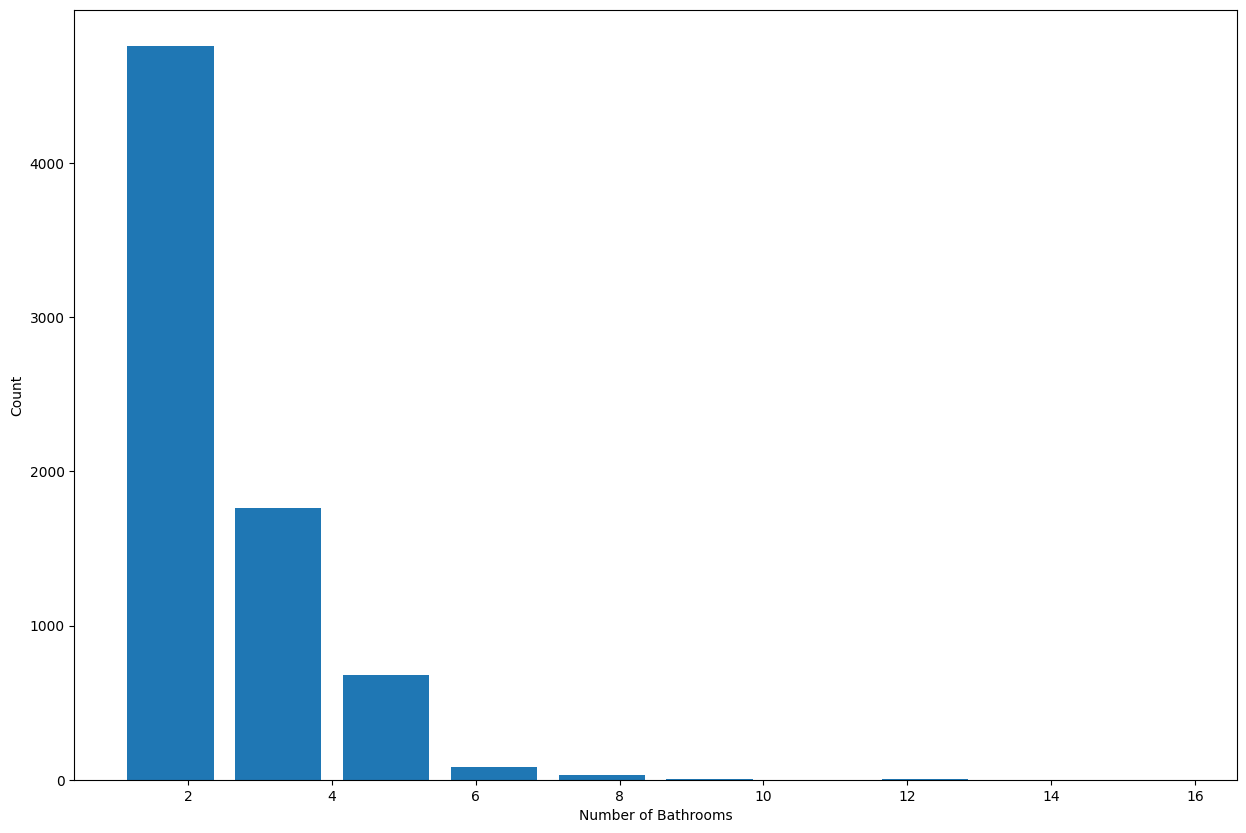

In [56]:
#look at the distribution of the feature

plt.hist(df8.bath, rwidth=0.8)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

- The majority of properties have two bathrooms

In [57]:
#look at rows with more than 10 bathrooms

df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


> **Once again, the real estate expert is summoned who is of the opinion that it is unsual to have >2 bathrooms than the number of bedrooms in a property.** 

In [58]:
#the rule of thumb is thus-

df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


 > Let's say a 4BHk has 4 attached bathrooms. And there's a guest bathroom. So a total of five. Anything else could be considered an outlier. 

In [59]:
#so we remove them

df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [60]:
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [61]:
#drop size and price per sqft as their purpose has been met

df10 = df9.drop(['size', 'price_per_sqft'], axis = 'columns')
df10.head(2)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3


## One Hot Encoding for Location

**One hot encoding** is a common method to deal with categorical variables in machine learning. This method converts categorical information into zeroes & ones which can be fed into the ML model because computers do not understand strings. 

One can manually create the binary values but pandas has the `get_dummies` method which makes things easier. 

In [62]:
#specify dtype, else the result has Trues and Falses

dummies = pd.get_dummies(df10.location, dtype=int)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For each location, a dummy has been created.It returns 1 when true, 0 when false. 

### Note on Dummy Variable Trap

In regression analysis when dealing with dummy variables, it is likely that they are correlated with each other, i.e., they are multicolinear in nature. This makes it to difficult to seperate each of the dummy's individual impact on the target variable. 

When we use `one-hot encoding` for handling the categorical data, then one dummy variable (attribute) can be predicted with the help of other dummy variables. Using all dummy variables for regression models leads to a **dummy variable trap**. So, the regression models should be designed to exclude one dummy variable. 

In [63]:
#cocatenate the two dfs with one less dummy variable

df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head() 

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#the location column is no longer required

df_final = df11.drop('location', axis='columns')
df_final.head() 

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df_final.shape

(7239, 244)

## The Model

In [66]:
#first step is to define X and y

X = df_final.drop(['price'], axis = 'columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
X.shape

(7239, 243)

In [68]:
y = df_final.price 
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

### Split the data

The train-test split divides the data once into distinct training and test sets used for initial model evaluation. Here, we take the test set to be 20%. 

80% will be used for training the model.

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


## Linear Regression Model

This model assumes a **linear relationship** between the target and the features and uses the **method of least squares** to fit a regression line on the data. 

In [70]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_test, y_test)

0.8629132245229444

## Use K Fold cross validation to measure accuracy of our LinearRegression model

> `Cross-validation` is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.
> The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

[K-Fold Cross Validation](https://machinelearningmastery.com/k-fold-cross-validation/)



In [71]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv) 

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

## Find best model using GridSearchCV

`GridSearchCV` is a technique to search through the best parameter values from the given set of the grid of parameters. It is another cross validation method to fish out to the best combination of hyperparameters and the best model for the data. 

Here, we are going to build a helper function which takes the dictionary of three models- `linear regression`, `decision tree`, and `lasso regression`; with two of their parameters. It then fits the data using cross validation for each of the models, gets their individual scores and returns the best combination of parameters and the best score. Finally, it is returned as dataframe for visual ease. 

In [72]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y) 

,model,best_score,best_params
0,linear_regression,0.847796,{'positive': False}
1,lasso,0.726887,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.669036,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


## Test the model for few properties

Once trained, it is imperative to test the model and validate the predictions. 

In [73]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lm.predict([x])[0]

In [74]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

83.86570258311873

In [75]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

86.08062284986642

In [76]:
predict_price('Whitefield',1000, 2, 2)

53.726372072434984

In [77]:
predict_price('Whitefield',1000, 3, 2)

57.443318779202855

In [78]:
predict_price('Whitefield',1000, 3, 4)

54.43926589916248

## Export the tested model to a pickle file

In [79]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lm,f)

## Export location and column information to a file that will be useful later on in the prediction application

In [80]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

## A Note on Housing Price Models- Hedonic Pricing Model

As is well known, any real estate property's value is determined by a lot of factors such as location, ease of commute/access to key areas,as well as any benefits accrued due to using the said property. This is captured by the Hedonic pricing model. 

> Hedonic pricing captures a **consumer’s willingness to pay** for what they perceive are `environmental differences` that add or detract from the intrinsic value of an asset or property.
In the real estate market, wherein the price of a building or piece of land is determined by the characteristics of both the property itself (i.e., `internal factors` like its size, appearance, features like solar panels or state-of-the-art faucet fixtures, and condition) and its surrounding environment (i.e., `external factors` such as if the neighborhood has a high crime rate and/or is accessible to schools and a downtown area, the level of water and air pollution, or the value of other homes close by).


[Hedonic Pricing](https://www.investopedia.com/terms/h/hedonicpricing.asp)


## Future Scope

This data does not have a date/time feature, maybe adding that and seeing how prices and factors have changed over time could be interesting. In other words, *studying the impact of real estate inflation.* 
- Do the predicted prices reflect the the impact of inflation? 
- How has demand changed over time?
- What are the factors behind the change, if any? 

## References

1. [Linear Regression SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
2. [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
3. [Lasso Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
4. [K-Fold Cross Validation](https://machinelearningmastery.com/k-fold-cross-validation/)
5. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
6. [Hedonic Pricing](https://www.investopedia.com/terms/h/hedonicpricing.asp)
7. [Economics of Housing Market](https://kkholodilin.github.io/Test_HE/ch-Market.html)
8. [GitHub Reference](https://github.com/codebasics/py/blob/master/DataScience/BangloreHomePrices/model/banglore_home_prices_final.ipynb)
    